# Swisscom Challenge : Identifying similar zones

In this assignment we are going to be using the [Swisscom Heatmaps API](https://digital.swisscom.com/products/heatmaps/info) to identify similar zones based on density evolution though the day.

This API provides hourly density information based on SIM card data, for the whole swiss territory. The resolution of the data is a 100mx100m grid.

To access the API and the data you need to register. There is a free demo plan, that lets you access data from the 27th of January 2020. This day will be our main focus throughout this notebook.

## Preliminary steps

The access tokens for the API are stored in a `.env` file with the following keys :
- `CLIENT_ID` : is the client id from the Authorization portal
- `CLIENT_SECRET` : is the client secret for the API

Such tokens can be created by creating an application under the right subscription in the [Portal](https://digital.swisscom.com/my/subscriptions/). After approval (which usually takes less than an hour) you are good to go !

## Importing necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

# custom modules
import osm_tiles
import heatmaps_api
import visualize

In [4]:
# defining constants for columns
TILES_KEY = 'tiles'
TILE_ID_KEY = 'tileId'
REQUEST_NBR = 'req_nbr'
SCORE_KEY = 'score'

In [3]:
importlib.reload(heatmaps_api)
# get an api handle from oauth using the CLIENT_ID and CLIENT_SECRETS defined in .env
api_handle = heatmaps_api.get_api_handle()
heatmaps_api.check_token_validity(api_handle)

Token expires on: 30 December 2021 at 14:30:13


When calling the `/grids/districts/{district_number}` api endpoint we get a list of objects:
- `tileId` : ID of the tile (integer)
- `ur` : upper right coordinates of the tile in WGS84
    - `x` : longitude (double)
    - `y` : latitude (double)
- `ll` : lower left coordinates of the tile in WGS84
    - `x` : longitude (double)
    - `y` : latitude (double)


In [38]:
def fetch_tile_ids_for_district(api_handle, district_nbr):
    """
    Given a district number, fetch the tile ids in that district

    :param api_handle: the oauth object to make requests
    :param district_nbr: the district number to query tiles for
    :return: Dataframe with tiles for the district
    """
    f_name_tile_coords = f'data/tiles_coords_{district_nbr}.pkl'
    # check if there already exists a cached version of the requested data
    if not os.path.exists(f_name_tile_coords):
        ol_tiles_response = heatmaps_api.get_tile_ids_from_district(api_handle, district_nbr)
        ol_tiles_json = ol_tiles_response.json()
        df = pd.json_normalize(ol_tiles_json[TILES_KEY], sep='_')
        df.to_pickle(f_name_tile_coords)
    else:
        print(f'Loading tile coords for district nbr {district_nbr} from cached file')
        df = pd.read_pickle(f_name_tile_coords)
    return df

In [115]:
def fetch_scores(api_handle, tile_coords_df, district_nbr, date_range):
    """
    Get the scores of all the tiles in :tile_coords_df: for a certain :date_range:

    :param api_handle: the oauth object to make requests
    :param tile_coords_df: a Dataframe with tile infos
    :param district_nbr: the district number to query scores for
    :param date_range: the time intervals for which to query the scores
    :return: Dataframe with scores for tiles that have at least 50% valid data,
    other tiles are dropped
    """
    file_name_scores = f'data/scores_clean_{district_nbr}.pkl'
    if not os.path.exists(file_name_scores):
        # map request numbers to tiles to not exceed MAX_NB_TILES_REQUEST
        request_df = tile_coords_df.copy()
        request_df[REQUEST_NBR] = request_df.index.map(lambda x: x//heatmaps_api.MAX_NB_TILES_REQUEST)

        results_hours = []
        for query_date in date_range:
            print(query_date)
            results = []
            for group, df_req in request_df.groupby(REQUEST_NBR):
                tile_ids_to_request = df_req.tileId.tolist()
                tiles_response = heatmaps_api.get_dwell_density(api_handle, query_date, tile_ids_to_request)
                json_response = tiles_response.json()
                if json_response.get(TILES_KEY):
                    results += json_response[TILES_KEY]
            df = pd.json_normalize(results).rename(columns={SCORE_KEY: query_date}).set_index(TILE_ID_KEY)
            results_hours.append(df)

        copied_coords_df = request_df.drop(columns=[REQUEST_NBR]).set_index(TILE_ID_KEY)
        score_df = copied_coords_df.join(results_hours)

        # droping NaN cells
        scores_clean = score_df.dropna(thresh=12).fillna(10)

        scores_clean.to_pickle(file_name_scores)
    else:
        print(f'Loading tile scores for district nbr {district_nbr} from cached file')
        scores_clean = pd.read_pickle(file_name_scores)
    return scores_clean

In [113]:
# lausanne, ouest-lausanne,
district_nbrs = [2225, 2229]

tile_coords = []
for district_nbr in district_nbrs:
    tile_coords.append(fetch_tile_ids_for_district(api_handle, district_nbr=district_nbr))
tile_coords_df_all = pd.concat(tile_coords).drop_duplicates()
tile_coords_df_all.head()

Loading tile coords for district nbr 2225 from cached file
Loading tile coords for district nbr 2229 from cached file


tileId      ll_x       ll_y      ur_x       ur_y
0  23975936  6.575053  46.575386  6.576343  46.576296
1  23982862  6.575038  46.576286  6.576328  46.577195
2  23989789  6.575024  46.577185  6.576314  46.578095
3  23996717  6.575010  46.578085  6.576300  46.578994
4  23975935  6.576371  46.574497  6.577661  46.575406

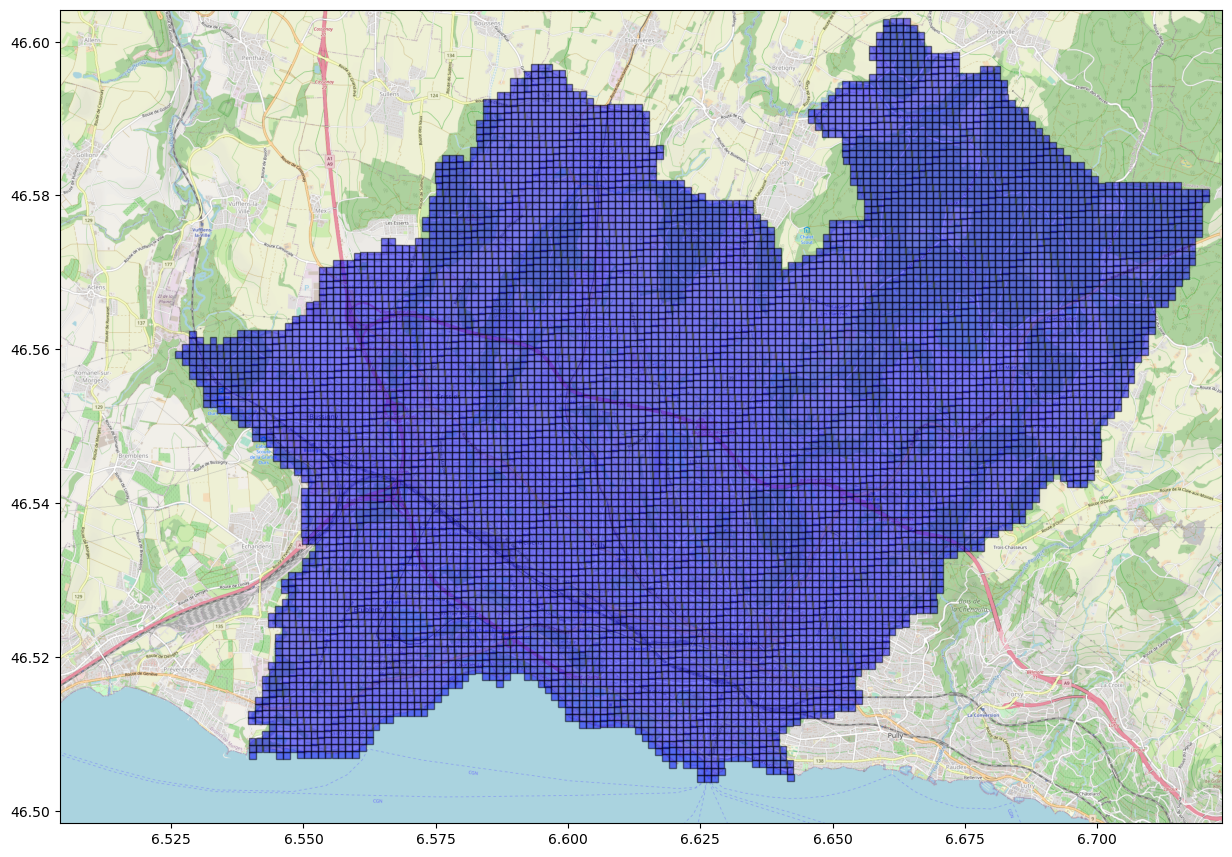

In [114]:
importlib.reload(osm_tiles)
importlib.reload(visualize)
# plot all tiles
zoom = 14
stitched_14, bbox_14, map_size_14 = osm_tiles.get_stitched_map_and_bbox(tile_coords_df_all, zoom, verbose=False)
visualize.plot_all_tiles_on_map(tile_coords_df_all, stitched_14, bbox_14, map_size=map_size_14)

In [117]:
# hourly for demo day
hourly_range = pd.date_range(start='2020-01-27', end='2020-01-28', freq='1H', closed='left')
scores_l = []
for district_nbr, tile_coords_df in zip(district_nbrs, tile_coords):
    print(district_nbr)
    scores_clean = fetch_scores(api_handle, tile_coords_df, district_nbr, hourly_range)
    scores_l.append(scores_clean)
scores_clean_all = pd.concat(scores_l).drop_duplicates()
scores_clean_all.head()

2225
Loading tile scores for district nbr 2225 from cached file
2229
Loading tile scores for district nbr 2229 from cached file


ll_x       ll_y      ur_x       ur_y  2020-01-27 00:00:00  \
tileId                                                                    
23610282  6.585037  46.521485  6.586326  46.522394                 10.0   
23617155  6.585022  46.522385  6.586311  46.523294                 10.0   
23624029  6.585008  46.523284  6.586297  46.524193                 23.0   
23617154  6.586340  46.521495  6.587629  46.522404                 10.0   
23624028  6.586326  46.522394  6.587614  46.523304                 34.0   

          2020-01-27 01:00:00  2020-01-27 02:00:00  2020-01-27 03:00:00  \
tileId                                                                    
23610282                 10.0                 10.0                 10.0   
23617155                 22.0                 23.0                 23.0   
23624029                 31.0                 32.0                 32.0   
23617154                 23.0                 24.0                 24.0   
23624028                 45.0                 46.0                 46.0   

          2020-01-27 04:00:00  2020-01-27 05:00:00  ...  2020-01-27 14:00:00  \
tileId                                              ...                        
23610282                 10.0                 10.0  ...                 43.0   
23617155                 23.0                 23.0  ...                 87.0   
23624029                 32.0                 32.0  ...                104.0   
23617154                 24.0                 24.0  ...                 36.0   
23624028                 46.0                 46.0  ...                 61.0   

          2020-01-27 15:00:00  2020-01-27 16:00:00  2020-01-27 17:00:00  \
tileId                                                                    
23610282                 42.0                 38.0                 34.0   
23617155                 85.0                 74.0                 61.0   
23624029                104.0                 88.0                 67.0   
23617154                 36.0                 34.0                 34.0   
23624028                 61.0                 59.0                 58.0   

          2020-01-27 18:00:00  2020-01-27 19:00:00  2020-01-27 20:00:00  \
tileId                                                                    
23610282                 27.0                 21.0                 10.0   
23617155                 46.0                 35.0                 30.0   
23624029                 53.0                 42.0                 36.0   
23617154                 30.0                 29.0                 28.0   
23624028                 55.0                 54.0                 54.0   

          2020-01-27 21:00:00  2020-01-27 22:00:00  2020-01-27 23:00:00  
tileId                                                                   
23610282                 10.0                 10.0                 10.0  
23617155                 27.0                 23.0                 10.0  
23624029                 32.0                 30.0                 21.0  
23617154                 27.0                 25.0                 10.0  
23624028                 51.0                 48.0                 34.0  

[5 rows x 28 columns]

In [118]:
importlib.reload(visualize)
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(10, 10))
stitched_14_clean, bbox_14_clean, map_size_14_clean = osm_tiles.get_stitched_map_and_bbox(scores_clean_all, zoom, verbose=False)
anim = visualize.animated_plot(fig, ax, scores_clean_all, stitched_14_clean, bbox_14_clean, map_size_14_clean, hourly_range)
plt.close()

In [119]:
HTML(anim.to_html5_video())

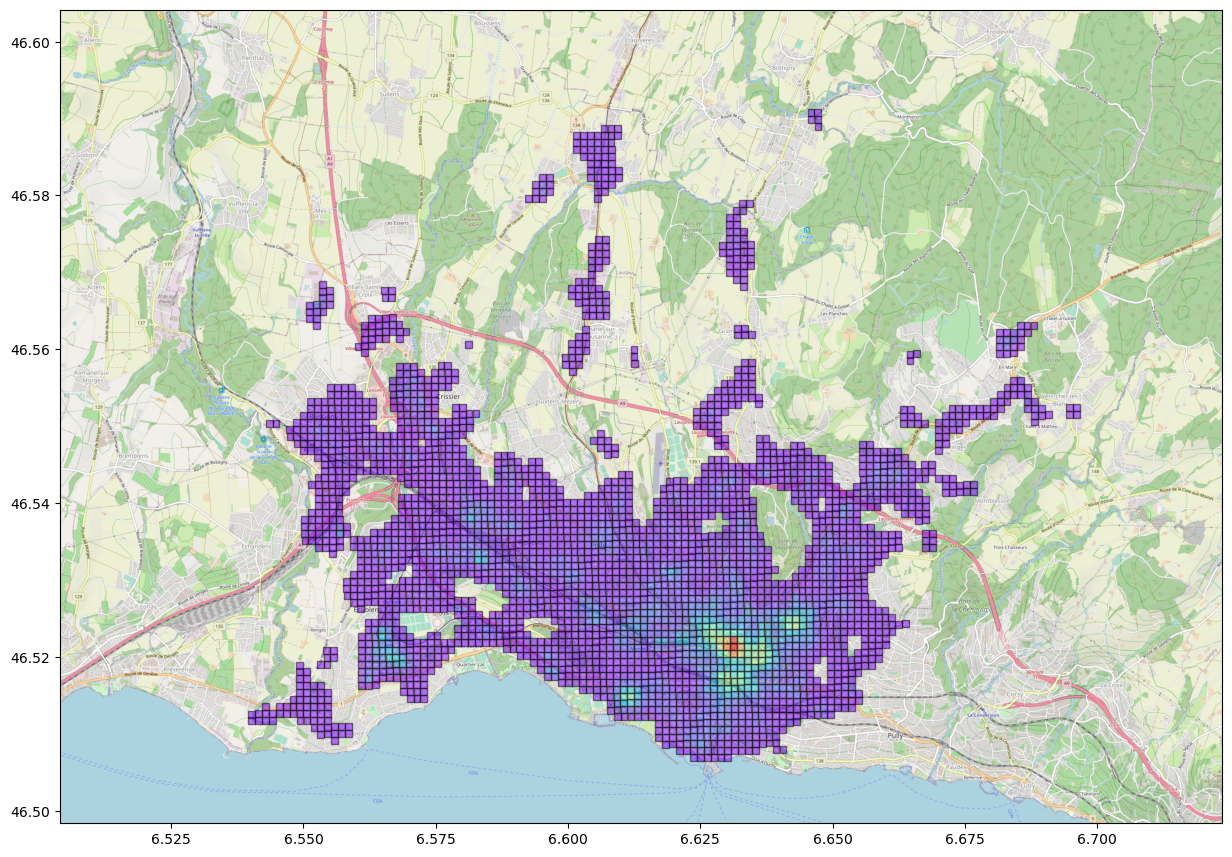

In [120]:
visualize.plot_all_tiles_on_map(scores_clean_all, stitched_14, bbox_14, map_size_14, hourly_range[15])

In [121]:
scores = scores_clean_all.drop(columns=['ll_x', 'll_y', 'ur_x', 'ur_y'])
scores.head()


2020-01-27 00:00:00  2020-01-27 01:00:00  2020-01-27 02:00:00  \
tileId                                                                    
23610282                 10.0                 10.0                 10.0   
23617155                 10.0                 22.0                 23.0   
23624029                 23.0                 31.0                 32.0   
23617154                 10.0                 23.0                 24.0   
23624028                 34.0                 45.0                 46.0   

          2020-01-27 03:00:00  2020-01-27 04:00:00  2020-01-27 05:00:00  \
tileId                                                                    
23610282                 10.0                 10.0                 10.0   
23617155                 23.0                 23.0                 23.0   
23624029                 32.0                 32.0                 32.0   
23617154                 24.0                 24.0                 24.0   
23624028                 46.0                 46.0                 46.0   

          2020-01-27 06:00:00  2020-01-27 07:00:00  2020-01-27 08:00:00  \
tileId                                                                    
23610282                 10.0                 21.0                 32.0   
23617155                 24.0                 36.0                 62.0   
23624029                 33.0                 46.0                 68.0   
23617154                 25.0                 30.0                 33.0   
23624028                 47.0                 54.0                 58.0   

          2020-01-27 09:00:00  ...  2020-01-27 14:00:00  2020-01-27 15:00:00  \
tileId                         ...                                             
23610282                 40.0  ...                 43.0                 42.0   
23617155                 82.0  ...                 87.0                 85.0   
23624029                 92.0  ...                104.0                104.0   
23617154                 36.0  ...                 36.0                 36.0   
23624028                 60.0  ...                 61.0                 61.0   

          2020-01-27 16:00:00  2020-01-27 17:00:00  2020-01-27 18:00:00  \
tileId                                                                    
23610282                 38.0                 34.0                 27.0   
23617155                 74.0                 61.0                 46.0   
23624029                 88.0                 67.0                 53.0   
23617154                 34.0                 34.0                 30.0   
23624028                 59.0                 58.0                 55.0   

          2020-01-27 19:00:00  2020-01-27 20:00:00  2020-01-27 21:00:00  \
tileId                                                                    
23610282                 21.0                 10.0                 10.0   
23617155                 35.0                 30.0                 27.0   
23624029                 42.0                 36.0                 32.0   
23617154                 29.0                 28.0                 27.0   
23624028                 54.0                 54.0                 51.0   

          2020-01-27 22:00:00  2020-01-27 23:00:00  
tileId                                              
23610282                 10.0                 10.0  
23617155                 23.0                 10.0  
23624029                 30.0                 21.0  
23617154                 25.0                 10.0  
23624028                 48.0                 34.0  

[5 rows x 24 columns]

In [122]:
scores_array = scores.to_numpy()
norm_scores = scores_array / scores_array.max(axis=1).reshape(-1, 1)

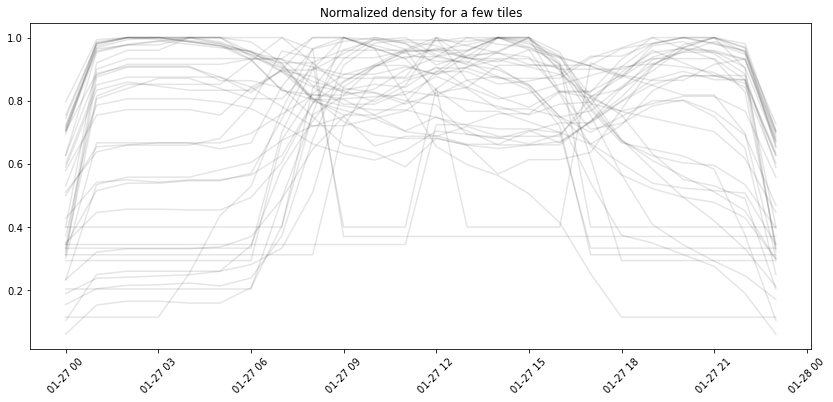

In [123]:
import random
x_values = scores.columns.to_list()
dims = norm_scores.shape
sampled_tiles = random.sample(range(dims[0]), 40)

plt.figure(figsize=(14,6))
for t_series in norm_scores[sampled_tiles,:]:
    plt.plot(x_values, t_series, alpha=0.1, c='k')
plt.title('Normalized density for a few tiles')
plt.xticks(rotation=45)
plt.show()


In [124]:
# prepare data for clustering
# format needs to be (num_time_series, max_series_length, 1)
# so for us : (num_tiles, 24, 1)

tiles_time_series = norm_scores[:,:,np.newaxis]
tiles_time_series.shape

(3194, 24, 1)

In [125]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=1000, random_state=42)
model.fit(tiles_time_series)
scores_clean_all['class'] = model.labels_

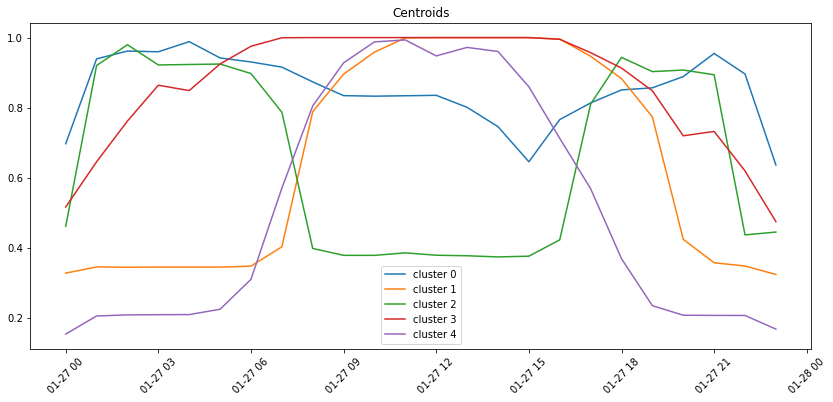

In [126]:
plt.figure(figsize=(14,6))
for i, centroid in enumerate(model.cluster_centers_):
    plt.plot(x_values, centroid, label=f'cluster {i}')
plt.title('Centroids')
plt.xticks(rotation=45)
plt.legend()
plt.show()

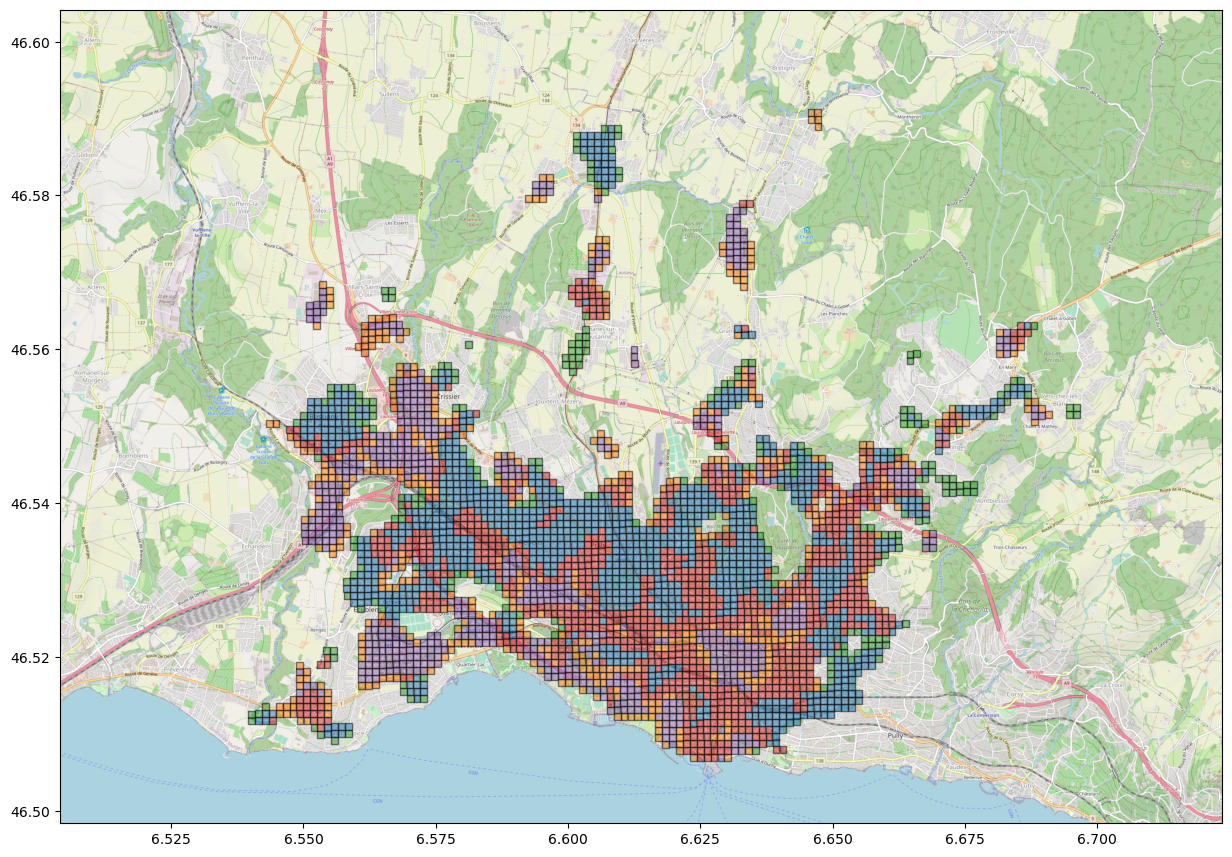

In [127]:
importlib.reload(osm_tiles)
importlib.reload(visualize)
visualize.plot_all_tiles_on_map(scores_clean_all, stitched_14, bbox_14, map_size_14, 'class')